In [26]:
import math

class HeadDirectedCell:

    def __init__(self, init_angle, delta_angle):

        # the angle from the animal head direction
        self.angle = init_angle

        # pai*(1/num of HD cells in ring)
        self.delta_angle = delta_angle

        # for printing and debug
        self.angle_pi_advance = HeadDirectedCell.get_angles_pi_advance(init_angle)

        # for plots
        self.ret_memory = []

        # current spik ret
        self.ret = 0
        self.set_ret()

    @staticmethod
    def add_to_angle(old, angle_to_add):

        output = old + angle_to_add

        if output >= 2 * math.pi or output <= -2 * math.pi:
            output = output - 2*math.pi*int(output/(2*math.pi))

        return output

    @staticmethod
    def get_angles_pi_advance(angle: int):
        return angle/math.pi

    def reset_ret_memory(self):
        self.ret_memory = [self.ret]

    def set_ret(self):
        new_ret = max(0.0, math.cos(self.angle))
        self.ret_memory.append(new_ret)
        self.ret = new_ret

    def set_angle(self, new_angle):
        self.angle = new_angle
        self.angle_pi_advance = HeadDirectedCell.get_angles_pi_advance(new_angle)
        self.set_ret()

    def increase_angel(self):
        new_angle = HeadDirectedCell.add_to_angle(self.angle, self.delta_angle)
        self.set_angle(new_angle)

    def decrease_angel(self):
        new_angle = HeadDirectedCell.add_to_angle(self.angle, -self.delta_angle)
        self.set_angle(new_angle)
        

In [3]:
import abc
import math


class InterneuronCall:

    def __init__(self, head_direction_call: HeadDirectedCell,
                 angle_delta,
                 transferring_threshold=0):

        # init ret no movement
        self.ret = 0

        # cell to update
        self.head_direction_call = head_direction_call

        # 2pai*(1/num of HD cells in ring)
        self.angle_delta = angle_delta

        # ret point the cell can't transfer ret >= angle_delta
        self.transferring_threshold = max(transferring_threshold, angle_delta)

    @abc.abstractmethod
    def increase_ret(self, amount):
        """ update the head direction call until rat < transferring threshold """
        return


class CWInterneuronCall(InterneuronCall):

    def increase_ret(self, amount):

        self.ret += amount

        while self.ret >= self.transferring_threshold:
            self.head_direction_call.decrease_angel()
            self.ret -= self.angle_delta


class CCWInterneuronCall(InterneuronCall):

    def increase_ret(self, amount):

        self.ret += amount

        while self.ret >= self.transferring_threshold:
            self.head_direction_call.increase_angel()
            self.ret -= self.angle_delta


In [5]:
def str_angle(angle):

    advance = angle/math.pi
    return str(advance) + "pi"

In [9]:
class SpeedCell:

    @staticmethod
    def add_current_to_channel(channel: [InterneuronCall], current_amount):

        for cw_cell in channel:
            cw_cell.increase_ret(current_amount)

In [14]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [21]:
class Ring:

    def __init__(self, neurons_amount):

        self.neurons_amount = neurons_amount

        self.speed_cell = SpeedCell()

        self.head_direction_cells = self.create_head_cells_ring(neurons_amount)

        self.right_channel = Ring.create_right_channel(self.head_direction_cells)

        self.left_channel = Ring.create_left_channel(self.head_direction_cells)

        self.head_index = 0

    @staticmethod
    def get_dela_angle(neurons_amount):
        return (2*math.pi)/neurons_amount

    @staticmethod
    def create_head_cells_ring(neurons_amount: int):

        head_cells_amount = neurons_amount
        cells_list = []

        next_neuron_angle = 0
        dela_angle = Ring.get_dela_angle(head_cells_amount)

        while next_neuron_angle < 2*math.pi:
            cells_list.append(HeadDirectedCell(next_neuron_angle, dela_angle))
            next_neuron_angle += dela_angle

        return cells_list

    @staticmethod
    def create_right_channel(head_direction_cells: [HeadDirectedCell]):

        cw_cells = []

        for hd_cell in head_direction_cells:
            cw_cells.append(CWInterneuronCall(hd_cell, hd_cell.delta_angle))

        return cw_cells

    @staticmethod
    def create_left_channel(head_direction_cells: [HeadDirectedCell]):

        ccw_cells = []

        for hd_cell in head_direction_cells:
            ccw_cells.append(CCWInterneuronCall(hd_cell, hd_cell.delta_angle))

        return ccw_cells

    def update_head_direction(self):

        for i in range(self.neurons_amount):
            if self.head_direction_cells[i].angle == 0:
                self.head_index = i
                return

    def add_current_to_right_channel(self, current_amount):
        self.speed_cell.add_current_to_channel(self.right_channel, current_amount)
        self.update_head_direction()

    def add_current_to_left_channel(self, current_amount):
        self.speed_cell.add_current_to_channel(self.left_channel, current_amount)
        self.update_head_direction()

    def plot_ring_history(self):
        colors = get_cmap(self.neurons_amount)

        fig, axs = plt.subplots(self.neurons_amount, sharex=True, sharey=True)

        dif_amount = len(self.head_direction_cells[0].ret_memory)
        for i in range(self.neurons_amount):
            axs[i].plot(range(dif_amount), self.head_direction_cells[i].ret_memory,
                        color=colors(i))
            axs[i].set(ylabel='n '+str(i))

        plt.show()

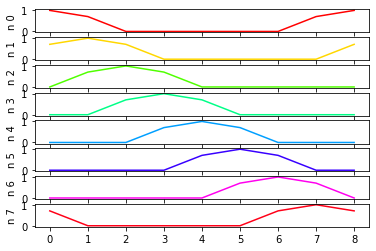

In [24]:
ring = Ring(8)
ring.add_current_to_right_channel(2*math.pi)
ring.plot_ring_history()

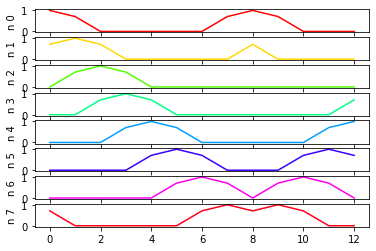

In [25]:
ring.add_current_to_left_channel(math.pi)
ring.plot_ring_history()